In [1]:
import os
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
from dotenv import load_dotenv

load_dotenv()

## Create the LLM
llm =  init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [3]:
# from sentence_transformers import SentenceTransformer
# # Save the model locally


# model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
# model.save("embedding_model/")

### 1. Create Specialized Agents

### Import Tools

takes some time to load vector store and embedding model.

In [4]:
from crop_management_tools.crop_calendar.crop_calendar_tool import get_crop_calendar, get_crops_by_month
#from crop_management_tools.crop_cultivation_guide.retriever_tool import retrieve_crop_cultivation_info
from open_meteo_weather_tool.weather_tool import get_weather, query_weather_variables

#### Testing Tools

### JSON files method

In [5]:
import os
import json

In [6]:
def search_filename(crop_name: str) -> str:
    """
    Search for the JSON filename corresponding to a given crop name.

    Args:
        crop_name (str): The name of the crop (case-insensitive).
    
    Returns:
        str: The filename of the crop JSON file if found, otherwise None.

    Notes:
        - Looks inside `crop_management_tools/crop_cultivation_guide/crop_cultivation_information`.
        - Assumes filenames follow the convention `<crop_name>.json` (lowercase).
    """
    print("SEARCHING FILE!")
    docs_path = "crop_management_tools/crop_cultivation_guide/crop_cultivation_json"
    for fname in os.listdir(docs_path):
        if fname.startswith(crop_name.lower()) and fname.endswith(".json"):
            return fname
    return None

In [7]:
def get_keys(filename: str) -> list:
    """
    Retrieve all top-level keys from a given crop JSON file.

    Args:
        filename (str): The name of the crop JSON file.
    
    Returns:
        list: A list of keys available in the JSON file.

    Notes:
        - Useful to check what sections (e.g., "Introduction", "Requirements", etc.)
          are available for a crop.
    """
    print("GETTING KEYS!")
    docs_path = "crop_management_tools/crop_cultivation_guide/crop_cultivation_json"
    with open(os.path.join(docs_path, filename), "r", encoding="utf-8") as f:
        data = json.load(f)
        return list(data.keys())

In [8]:
def get_context(filename: str, key: str) -> str:
    """
    Retrieve the content under a specific key from a crop JSON file.

    Args:
        filename (str): The name of the crop JSON file.
        key (str): The section key to fetch content from (e.g., "Soil", "Varieties").
    
    Returns:
        str: The text content under the given key, or "Key not found" if the key does not exist.

    Notes:
        - Some keys may be nested; this function only supports direct key lookup.
        - For nested structures, you may need to expand this function to traverse deeper.
    """
    print("GETTING CONTEXT!")
    docs_path = "crop_management_tools/crop_cultivation_guide/crop_cultivation_json"
    with open(os.path.join(docs_path, filename), "r", encoding="utf-8") as f:
        data = json.load(f)
        context = data.get(key, "Key not found")
        print(context)
        return context

In [9]:
crop_name = "Ginger"
filename = search_filename(crop_name)
keys = get_keys(filename)
get_context(filename, keys[0])

SEARCHING FILE!
GETTING KEYS!
GETTING CONTEXT!
Ginger is an important spice and used in different forms such as raw ginger, dry ginger, bleached dry ginger, ginger powder oleoresin, ginger beer, ginger candy, ginger wine etc. Kerala is the major ginger growing state. Other major ginger growing states are Orissa, Meghalaya, Himachal Pradesh and Karnataka. Ginger grows in warm and humid climate.


'Ginger is an important spice and used in different forms such as raw ginger, dry ginger, bleached dry ginger, ginger powder oleoresin, ginger beer, ginger candy, ginger wine etc. Kerala is the major ginger growing state. Other major ginger growing states are Orissa, Meghalaya, Himachal Pradesh and Karnataka. Ginger grows in warm and humid climate.'

### Weather Function

In [79]:
query_weather_variables('BHopal', 'temperature_2m')

USING FULL WEATHER FORECAST
USING CACHED WEATHER DATA
USING VARIABLE QUERY!


{'date': ['2025-08-16 18:30:00+00:00',
  '2025-08-16 21:30:00+00:00',
  '2025-08-17 00:30:00+00:00',
  '2025-08-17 03:30:00+00:00',
  '2025-08-17 06:30:00+00:00',
  '2025-08-17 09:30:00+00:00',
  '2025-08-17 12:30:00+00:00',
  '2025-08-17 15:30:00+00:00',
  '2025-08-17 18:30:00+00:00',
  '2025-08-17 21:30:00+00:00',
  '2025-08-18 00:30:00+00:00',
  '2025-08-18 03:30:00+00:00',
  '2025-08-18 06:30:00+00:00',
  '2025-08-18 09:30:00+00:00',
  '2025-08-18 12:30:00+00:00',
  '2025-08-18 15:30:00+00:00',
  '2025-08-18 18:30:00+00:00',
  '2025-08-18 21:30:00+00:00',
  '2025-08-19 00:30:00+00:00',
  '2025-08-19 03:30:00+00:00',
  '2025-08-19 06:30:00+00:00',
  '2025-08-19 09:30:00+00:00',
  '2025-08-19 12:30:00+00:00',
  '2025-08-19 15:30:00+00:00'],
 'temperature_2m': [25.51099967956543,
  24.81100082397461,
  24.861000061035156,
  27.01099967956543,
  30.411001205444336,
  30.661001205444336,
  29.361000061035156,
  26.26099967956543,
  24.861000061035156,
  24.361000061035156,
  24.01099967

In [62]:
get_crop_calendar("wheat")

CROP CALENDAR TOOL CALLED!


{'planting': ['November'],
 'sowing': ['November'],
 'growth': ['December', 'January', 'February'],
 'arrival': ['March', 'April']}

In [63]:
get_crops_by_month(8)

REVERSE CROP CALENDAR TOOL CALLED!


{'month': 'August',
 'crops': {'planting': ['chilli'],
  'sowing': ['chilli'],
  'growth': ['castor seed',
   'soybean',
   'cotton',
   'guar',
   'maize',
   'bajra',
   'paddy kharif',
   'moong',
   'sugar',
   'turmeric'],
  'arrival': ['No crops']}}

In [64]:
city = 'Bhopal'
weather_data = get_weather(city)
print(weather_data)

USING FULL WEATHER FORECAST
USING CACHED WEATHER DATA
{'date': ['2025-08-16 18:30:00+00:00', '2025-08-16 21:30:00+00:00', '2025-08-17 00:30:00+00:00', '2025-08-17 03:30:00+00:00', '2025-08-17 06:30:00+00:00', '2025-08-17 09:30:00+00:00', '2025-08-17 12:30:00+00:00', '2025-08-17 15:30:00+00:00', '2025-08-17 18:30:00+00:00', '2025-08-17 21:30:00+00:00', '2025-08-18 00:30:00+00:00', '2025-08-18 03:30:00+00:00', '2025-08-18 06:30:00+00:00', '2025-08-18 09:30:00+00:00', '2025-08-18 12:30:00+00:00', '2025-08-18 15:30:00+00:00', '2025-08-18 18:30:00+00:00', '2025-08-18 21:30:00+00:00', '2025-08-19 00:30:00+00:00', '2025-08-19 03:30:00+00:00', '2025-08-19 06:30:00+00:00', '2025-08-19 09:30:00+00:00', '2025-08-19 12:30:00+00:00', '2025-08-19 15:30:00+00:00'], 'temperature_2m': [25.51099967956543, 24.81100082397461, 24.861000061035156, 27.01099967956543, 30.411001205444336, 30.661001205444336, 29.361000061035156, 26.26099967956543, 24.861000061035156, 24.361000061035156, 24.01099967956543, 26.76

In [36]:
city = 'Bihar'
weather_data = get_weather(city)
print(weather_data)

USING FULL WEATHER FORECAST
USING CACHED WEATHER DATA
{'date': ['2025-08-16 18:30:00+00:00', '2025-08-16 21:30:00+00:00', '2025-08-17 00:30:00+00:00', '2025-08-17 03:30:00+00:00', '2025-08-17 06:30:00+00:00', '2025-08-17 09:30:00+00:00', '2025-08-17 12:30:00+00:00', '2025-08-17 15:30:00+00:00', '2025-08-17 18:30:00+00:00', '2025-08-17 21:30:00+00:00', '2025-08-18 00:30:00+00:00', '2025-08-18 03:30:00+00:00', '2025-08-18 06:30:00+00:00', '2025-08-18 09:30:00+00:00', '2025-08-18 12:30:00+00:00', '2025-08-18 15:30:00+00:00', '2025-08-18 18:30:00+00:00', '2025-08-18 21:30:00+00:00', '2025-08-19 00:30:00+00:00', '2025-08-19 03:30:00+00:00', '2025-08-19 06:30:00+00:00', '2025-08-19 09:30:00+00:00', '2025-08-19 12:30:00+00:00', '2025-08-19 15:30:00+00:00'], 'temperature_2m': [28.9064998626709, 28.256500244140625, 28.806499481201172, 32.10649871826172, 33.006500244140625, 31.6564998626709, 29.706501007080078, 28.506500244140625, 27.6564998626709, 26.9064998626709, 26.956501007080078, 29.556499

In [37]:
city = 'Rohtak'
weather_data = get_weather(city)
print(weather_data)

USING FULL WEATHER FORECAST
USING CACHED WEATHER DATA
{'date': ['2025-08-16 18:30:00+00:00', '2025-08-16 21:30:00+00:00', '2025-08-17 00:30:00+00:00', '2025-08-17 03:30:00+00:00', '2025-08-17 06:30:00+00:00', '2025-08-17 09:30:00+00:00', '2025-08-17 12:30:00+00:00', '2025-08-17 15:30:00+00:00', '2025-08-17 18:30:00+00:00', '2025-08-17 21:30:00+00:00', '2025-08-18 00:30:00+00:00', '2025-08-18 03:30:00+00:00', '2025-08-18 06:30:00+00:00', '2025-08-18 09:30:00+00:00', '2025-08-18 12:30:00+00:00', '2025-08-18 15:30:00+00:00', '2025-08-18 18:30:00+00:00', '2025-08-18 21:30:00+00:00', '2025-08-19 00:30:00+00:00', '2025-08-19 03:30:00+00:00', '2025-08-19 06:30:00+00:00', '2025-08-19 09:30:00+00:00', '2025-08-19 12:30:00+00:00', '2025-08-19 15:30:00+00:00'], 'temperature_2m': [28.1875, 27.88749885559082, 28.1875, 28.787500381469727, 31.4375, 30.88749885559082, 30.237499237060547, 28.587499618530273, 28.13749885559082, 26.737499237060547, 26.487499237060547, 28.38749885559082, 30.1875, 30.9375,

### Create SubAgents

In [10]:
weather_agent = create_react_agent(
    model=llm,
    tools=[get_weather, query_weather_variables],  
    name="weather_expert",
    prompt="""
    You are a weather forecasting expert specialized in agricultural insights.

    You have access to two tools:

    1. `get_weather(city_name: str)`
       - Takes the name of an Indian city as input.
       - Fetches important weather variables from the local `.cache` (if available and fresh),
         or calls the Open-Meteo API to retrieve new data, then stores it in `.cache`.
       - Provides **3-hourly weather forecasts for the next 3 days**, tailored for agricultural needs. 
       - Variables include:
           - temperature_2m (°C): Air temperature at 2m above ground
           - relative_humidity_2m (%): Humidity at 2m above ground
           - evapotranspiration (mm): Combined water loss from soil + plants
           - soil_temperature_0cm, 6cm, 18cm (°C): Soil temperatures at different depths
           - precipitation (mm), precipitation_probability (%): Rainfall and chance of rain
           - soil_moisture_0_to_1cm, 1_to_3cm, 3_to_9cm, 9_to_27cm (m³/m³): Soil moisture profiles
           - wind_speed_10m (m/s): Wind speed at 10m above ground

    2. `query_weather_variables(city_name: str, variable: str)`
       - Fetches a **single weather variable with timestamps** for a given city.
       - Useful when the user only asks about one factor (e.g., "soil moisture" or "rainfall").
       - Supported variables:
           - temperature_2m (°C): Crop growth, pest activity, heat stress
           - relative_humidity_2m (%): Disease risk, transpiration
           - evapotranspiration (mm): Irrigation scheduling
           - soil_temperature_0cm, 6cm, 18cm (°C): Seed germination, root growth, moisture retention
           - precipitation (mm), precipitation_probability (%): Irrigation planning, harvest timing
           - soil_moisture_0_to_1cm, 1_to_3cm, 3_to_9cm, 9_to_27cm (m³/m³): Soil water availability
           - wind_speed_10m (m/s): Pollination, lodging risk, pesticide drift

    Guidelines:
    - Always use these tools to get data (from cache or API) instead of guessing.
    - Use `get_weather` when the user wants the **full forecast**.
    - Use `query_weather_variables` when the user wants **only one specific variable**.
    - Summarize results in a farmer-friendly format (avoid raw JSON).
    - Highlight key insights: rain chances, irrigation needs, soil moisture, and extreme conditions.
    - If the city name is missing or unclear, politely ask the user to clarify before fetching data.
    """
)


In [11]:
from langgraph.prebuilt import create_react_agent

crop_agent = create_react_agent(
    model=llm,
    tools=[search_filename, get_keys, get_context],
    name="crop_expert",
    prompt="""
    You are an agricultural crop cultivation expert.
    You have access to the following tools:

    1. `search_filename(crop_name: str) -> str`
       - Input: crop name
       - Output: filename of the JSON document containing cultivation guide.
       - If crop is not found, return None.

    2. `get_keys(filename: str) -> list`
       - Input: filename of crop JSON file
       - Output: list of available section keys in that file.

    3. `get_context(filename: str, key: str) -> str`
       - Input: filename and a section key
       - Output: detailed content under that key.

    Guidelines:
    - First, identify the crop the user is asking about.
    - Use `search_filename` to find the right file.
    - Next, use `get_keys` to see available sections in that file.
    - Match the user’s query with the most relevant section key.
    - Finally, use `get_context` to extract and present the answer.
    - Always return answers in simple, string format, farmer-friendly language.
    - If the crop name or section is missing/unclear, ask the user politely.
"""
)


In [12]:
crop_calendar_agent = create_react_agent(
    model=llm,
    tools=[get_crop_calendar, get_crops_by_month],
    name="crop_calendar_expert",
    prompt="""
    You are an agricultural crop calendar expert.
    You have access to the following tools:

    1. `get_crop_calendar(crop_name: str) -> dict`
       - Input: crop name (string).
       - Output: Dictionary containing stage-wise calendar (planting, sowing, growth, arrival) with month names.
       - Handles errors if crop is not found or data is missing.

    2. `get_crops_by_month(month: int) -> dict`
       - Input: month number (1–12).
       - Output: Dictionary with crops categorized by stage (planting, sowing, growth, arrival) for that month.
       - Handles errors if month is invalid.

    Guidelines:
    - First, identify whether the user is asking by **crop name** or by **month**.
    - If user mentions a crop (e.g., "wheat calendar"), use `get_crop_calendar`.
    - If user mentions a month (e.g., "what to sow in July?"), use `get_crops_by_month`.
    - Always return answers in simple, farmer-friendly language.
    - Include both crop names and month names in your answers for clarity.
    - If input is unclear, politely ask the user whether they want information by crop or by month.
"""
)

In [109]:
# 1. retrieve_crop_cultivation_info
#       - This tool helps you find reliable, pre-stored documents about crop cultivation.
#       - It’s useful for answering questions about farming techniques, soil preparation, fertilizer schedules, pest control, irrigation methods, or crop-specific best practices.
#       - You give it a short search query (like “paddy irrigation in monsoon” or “organic wheat cultivation”), and it will return relevant information along with the source and title.

In [110]:
# crop_cultivation_agent = create_react_agent(
#     model=llm,
#     tools=[retrieve_crop_cultivation_info, get_crop_guide, get_crop_calendar],
#     name="knowledge_crop_expert",
#     prompt="""
# You are an agricultural knowledge assistant for Indian farmers, agronomists, and researchers.
# You can use three specialized tools to provide accurate, detailed answers:

# 1. retrieve_crop_cultivation_info
#    - Use this first when answering questions about farming techniques, soil preparation, fertilizer schedules, pest control, irrigation methods, or crop-specific best practices.
#    - It retrieves information from the RAG database with reliable, pre-stored documents.
#    - If it returns empty, irrelevant, or unclear results, then use tool (3) `get_crop_guide`.

# 2. get_crop_calendar
#    - Use this when someone asks about planting seasons, harvesting times, or the growth cycle of a crop.
#    - It provides month-by-month schedule (sowing, growing, harvesting).

# 3. get_crop_guide
#    - Use this **only if** tool (1) doesn’t provide relevant information.
#    - It gives a fallback “cultivation guide” text for a given crop name.
#    - Example use: “wheat”, “ginger”, “maize”.
#    - If the crop name is missing, ask the user to clarify first.

# Your task:
# - Read the user’s request carefully.
# - First try `retrieve_crop_cultivation_info` for cultivation questions.
# - If no useful results → fall back to `get_crop_guide`.
# - Each tools should be strictly called "only once".
# - Use `get_crop_calendar` for timeline/season-related queries.
# - Present answers in farmer-friendly, clear language (bullet points or tables).
# - If crop name/topic is unclear, politely ask the user to clarify before using any tool.
# """
# )


### Define supervisor

In [13]:
## add memory
checkpointer = InMemorySaver()

## create workflow
workflow = create_supervisor(
    [weather_agent, crop_agent, crop_calendar_agent],
    model=llm,
    checkpointer=checkpointer,
    prompt="""
You are a team supervisor managing three expert agents:

1. Weather Agent  
   - Specializes in providing location-based weather forecasts and atmospheric data.  
   - Useful when the user asks about current conditions, upcoming forecasts, temperature, rainfall, or other weather-related insights.  
   - Can return detailed hourly forecasts, so make sure to clarify the time range if needed.  

2. Crop Agent  
   - Specializes in answering questions about crop cultivation practices in India.  
   - Uses structured JSON guides stored in the system for each crop.  
   - Has access to the following tools:
       * `search_filename(crop_name: str)` → Finds the JSON file for a given crop.  
       * `get_keys(filename: str)` → Retrieves all available section keys from that crop’s guide.  
       * `get_context(filename: str, key: str)` → Extracts the detailed content under a given section.  
   - Process:
       * Identify the crop mentioned in the user’s query.  
       * Use `search_filename` to locate the file.  
       * Use `get_keys` to explore available sections.  
       * Match the query with the most relevant key.  
       * Use `get_context` to fetch the content.  
   - Always present the information in simple, farmer-friendly language.  
   - If the crop name or section is unclear, politely ask the user to clarify.  

3. Crop Calendar Agent  
   - Specializes in answering time-based agricultural queries.  
   - Has access to the following tools:
       * `get_crop_calendar(crop_name: str)` → Provides month-wise stages (planting, sowing, growth, arrival) for a specific crop.  
       * `get_crops_by_month(month: int)` → Provides all crops and their stages for a given month.  
   - Process:
       * If the user asks about a specific crop (e.g., "wheat calendar"), use `get_crop_calendar`.  
       * If the user asks about a specific month (e.g., "what can I sow in July?"), use `get_crops_by_month`.  
       * Return results in clear, farmer-friendly language.  
       * If the query is unclear, ask whether the user wants information by crop or by month.  

Your role as Supervisor:  
- Listen to the user’s query and decide which expert is best suited to respond.  
- Do not mention that you have retrieved the information from tools.  
- Use the information retrieved from tools to craft your response.  
- If a query requires input from multiple experts (e.g., weather + crop calendar), coordinate their responses in sequence.  
- Always respond in the same language the user used in their query.  
- Ensure answers are clear, concise, and tailored for farmers or agricultural professionals.  
""",
    output_mode="last_message",
)


In [16]:
config = {"configurable": {"thread_id": "abc@0"}}

In [17]:
# Compile with checkpointer
app = workflow.compile(
    checkpointer=checkpointer,
)

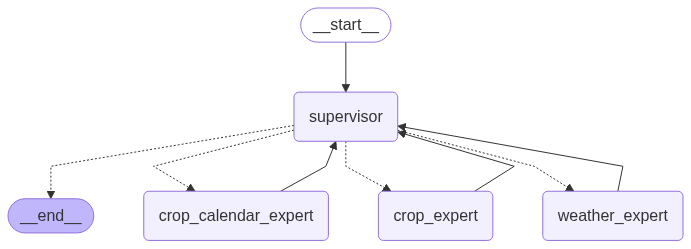

In [18]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
## create chat loop

result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "what are some diseases in ginger?"
        }
    ]
},
config = config)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 49
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
]

In [90]:
print(result["messages"][-1].pretty_print())

================================== Ai Message ==================================
Name: supervisor

धন্যবাদ! Do you have any other questions?
None


In [91]:
user_prompt = input("User: ")

while user_prompt.lower() != 'quit':
        print(f"User: {user_prompt}")
        ## trigger the graph and and the prompt is fed to the llm node to generate reponse
        result = app.invoke({"messages": [{"role":"user",
                                             "content": user_prompt}]},
                                             config=config)

        print(result["messages"][-1].content)

        user_prompt = input("User: ")


User: hi
नमस्ते! How can I assist you today?
User: what are soime diseases in ginger?
Yes, I meant ginger
User: what are diseases in bajra?
SEARCHING FILE!
GETTING KEYS!
GETTING CONTEXT!
{'Insect pests': [{'pest': 'Stem bores', 'control': 'Two sprayings with 2 litres of Eldrin 20 c.c.'}, {'pest': 'Grasshoppers', 'control': ['Two sprayings with 2 litres of Eldrin 20 c.c.', 'Dusting the crop with BHC 5 percent.']}], 'Diseases': [{'disease': 'Downy mildew', 'control': 'Seed treatment with fungicide like Dithane Z-78 or M-45 @ 2.0kg/ha in 800-1000 lit. of water.'}, {'disease': 'Smut', 'control': 'Treatment with Ceresan or Thirum @ 1-2 g/kg seeds is effective.'}, {'disease': 'Ergot', 'control': 'Seed treatment with 20% common salt solution followed by washing with fresh water and then treating with Ceresan or Thirum @ 1-2 g/kg seeds is effective.'}]}
Any other questions about Bajra or any other crop?


In [30]:
##new loop

import time

user_prompt = input("User: ")

while user_prompt.lower() != 'quit':
    
    result = app.invoke({"messages": [{"role": "user", "content": user_prompt}]},
                        config=config)
    print(result["messages"][-1].content)

    time.sleep(6)   # ✅ avoid 429 by spacing requests
    user_prompt = input("User: ")

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 42
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 40
}
]